In [1]:
from SurvivalEVAL import SurvivalEvaluator
import numpy as np
import pandas as pd
import torch
from pycop import simulation
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter

from dgp import DGP_Weibull_linear
from utility import convert_to_structured, kendall_tau_to_theta, lifelines_surv_to_matrix, make_time_bins, predict_median_time_from_survival_curves

import numpy as np
import pandas as pd
import torch

from utility import train_test_split_df

from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_ipcw

plt.style.use("default")
plt.rcParams.update({
    "axes.labelsize": "large",
    "axes.titlesize": "large",
    "font.size": 14.0,
    "legend.fontsize": "large",
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts} \usepackage{amstext} \usepackage{bm}"
})

def fit_predict_cox_survival(df_train, df_test, features):
    """
    Fit lifelines CoxPH and return survival curves on df_test:
    time_grid (m,), S_test (n,m)
    """
    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(df_train[["time", "event"] + features], duration_col="time", event_col="event")
    surv_df = cph.predict_survival_function(df_test[features])
    time_grid, S = lifelines_surv_to_matrix(surv_df)
    risks = cph.predict_log_partial_hazard(df_test[features]).values.reshape(-1)
    return cph, time_grid, S, risks

def eval_ibs_survivaleval(survival_outputs, time_bins, 
                         true_test_time, true_test_event,
                         test_time, test_event,
                         train_time, train_event,
                         num_points=10):

    survival_df = pd.DataFrame(survival_outputs, columns=time_bins.cpu().numpy())

    true_eval = SurvivalEvaluator(survival_df, time_bins, true_test_time, true_test_event)
    ibs_true = true_eval.integrated_brier_score(IPCW_weighted=False, num_points=num_points)

    eval_obs = SurvivalEvaluator(survival_df, time_bins,
                                 test_time, test_event,
                                 train_time, train_event)

    ibs_uncens = eval_obs.integrated_brier_score(IPCW_weighted=False, num_points=num_points)
    ibs_ipcw   = eval_obs.integrated_brier_score(IPCW_weighted=True,  num_points=num_points)

    return ibs_true, ibs_uncens, ibs_ipcw

def eval_ci_survivaleval(
    survival_outputs,      # (n_test, n_grid) survival probabilities
    time_bins,             # torch or np array (n_grid,)
    true_test_time, true_test_event,
    test_time, test_event,
    train_time, train_event,
    num_points=None,       # not used, keep signature if you want
    ties="All",
    pair_method="Comparable",
    tau=None,
):
    if hasattr(time_bins, "detach"):
        grid = time_bins.detach().cpu().numpy().astype(float)
    else:
        grid = np.asarray(time_bins, dtype=float)

    survival_df = pd.DataFrame(np.asarray(survival_outputs, dtype=float), columns=grid)

    eval_obs = SurvivalEvaluator(
        survival_df, time_bins,
        test_time, test_event,
        train_time, train_event
    )
    try:
        ci_harrell = float(eval_obs.concordance(ties=ties, pair_method=pair_method)[0])
    except ValueError:
        ci_harrell = np.nan

    true_eval = SurvivalEvaluator(
        survival_df, time_bins,
        true_test_time, true_test_event
    )
    try:
        ci_true = float(true_eval.concordance(ties=ties, pair_method="Comparable")[0])
    except ValueError:
        ci_true = np.nan

    # Grab predicted event times from the evaluator (SurvivalEVAL computes these internally)
    try:
        pred_times = np.asarray(eval_obs.predicted_event_times, dtype=float)
        risks = -pred_times

        y_train = convert_to_structured(train_time, train_event.astype(bool))
        y_test  = convert_to_structured(test_time,  test_event.astype(bool))

        if tau is None:
            # choose a safe tau where G_hat(tau)>0 is likely; use a lower quantile
            tau = float(np.quantile(train_time, 0.8))

        ci_uno = float(concordance_index_ipcw(y_train, y_test, risks, tau=tau)[0])
    except Exception:
        ci_uno = np.nan

    return float(ci_true), float(ci_harrell), float(ci_uno)

def _uv_seed(seed: int, tau: float) -> int:
    return int(seed * 1_000_003 + round(float(tau) * 10_000))

def run_bias_experiment(
    data_cfg,
    taus=(0.25, 0.5, 0.75),
    copula_name="clayton",
    seeds=range(5),
    device="cpu",
    dtype=torch.float64,
    num_points=10,
    train_frac=0.7,
    split_seed=0,
):
    alpha_c = data_cfg["alpha_e1"]
    gamma_c = data_cfg["gamma_e1"]
    alpha_e = data_cfg["alpha_e2"]
    gamma_e = data_cfg["gamma_e2"]
    n_samples = data_cfg["n_samples"]
    n_features = data_cfg["n_features"]

    settings = [
        {"label": "random", "tau": 0.0, "censor_use_x": False, "use_copula": False},
        {"label": "indep",  "tau": 0.0, "censor_use_x": True,  "use_copula": False},
    ] + [{"label": float(t), "tau": float(t), "censor_use_x": True, "use_copula": True} for t in taus]

    rows = []

    # loop seeds OUTSIDE settings so base DGP is shared
    for seed in seeds:
        # deterministic base RNG for torch objects
        g = torch.Generator(device=device)
        g.manual_seed(int(seed))

        # X ONCE per seed
        X = torch.rand((n_samples, n_features), generator=g, device=device, dtype=dtype)

        # coeffs ONCE per seed
        beta_event = 2 * torch.rand((n_features,), generator=g, device=device, dtype=dtype) - 1
        beta_cens  = 2 * torch.rand((n_features,), generator=g, device=device, dtype=dtype) - 1

        # event DGP ONCE per seed
        dgp_event_base = DGP_Weibull_linear(
            n_features, alpha_e, gamma_e,
            use_x=True, device=device, dtype=dtype,
            coeff=beta_event
        )

        # fixed split across everything
        split_rng_seed = int(split_seed)

        for s in settings:
            label = s["label"]
            tau = s["tau"]
            censor_use_x = s["censor_use_x"]
            use_copula = s["use_copula"]

            # uniforms
            if (not use_copula) or (tau == 0.0):
                rng = np.random.default_rng(int(seed))
                u = torch.tensor(rng.uniform(0, 1, n_samples), device=device, dtype=dtype)
                v = torch.tensor(rng.uniform(0, 1, n_samples), device=device, dtype=dtype)
            else:
                np.random.seed(_uv_seed(int(seed), float(tau)))
                theta = kendall_tau_to_theta(copula_name, float(tau))
                u_np, v_np = simulation.simu_archimedean(copula_name, 2, n_samples, theta=theta)
                u = torch.from_numpy(u_np).to(device=device, dtype=dtype).reshape(-1)
                v = torch.from_numpy(v_np).to(device=device, dtype=dtype).reshape(-1)

            # censoring DGP per setting (only use_x changes), coeff fixed
            dgp_cens = DGP_Weibull_linear(
                n_features, alpha_c, gamma_c,
                use_x=censor_use_x, device=device, dtype=dtype,
                coeff=beta_cens
            )

            # sample times                        
            t_c = dgp_cens.rvs(X, u)
            t_e = dgp_event_base.rvs(X, v)

            T = np.minimum(t_e, t_c)
            E = (t_e < t_c).astype(int)

            df = pd.DataFrame(X.detach().cpu().numpy(), columns=[f"X{i}" for i in range(n_features)])
            df["time"] = np.where(T <= 0, 1.0, T)
            df["event"] = E
            df["true_time"] = np.where(t_e <= 0, 1.0, t_e)
            df["true_censor"] = np.where(t_c <= 0, 1.0, t_c)

            df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["time", "true_time"]).reset_index(drop=True)

            # split (fixed)
            df_train, df_test = train_test_split_df(df, train_frac=train_frac, seed=split_rng_seed)
            features = [c for c in df.columns if c.startswith("X")]

            train_time  = df_train["time"].values
            train_event = df_train["event"].values
            test_time   = df_test["time"].values
            test_event  = df_test["event"].values

            true_test_time  = df_test["true_time"].values
            true_test_event = np.ones_like(true_test_time, dtype=int)

            # time grid varies by setting
            time_grid = make_time_bins(df["true_time"].values, event=None)
            time_bins = torch.tensor(time_grid, device=device, dtype=dtype)

            # fit CoxPH and predict survival
            cph, cox_time_grid, S, risks = fit_predict_cox_survival(df_train, df_test, features)

            # interpolate to grid
            S_interp = np.row_stack([
                np.interp(time_grid, cox_time_grid, S[i], left=1.0, right=S[i, -1])
                for i in range(S.shape[0])
            ])

            # IBS
            ibs_true, ibs_uncens, ibs_ipcw = eval_ibs_survivaleval(
                survival_outputs=S_interp,
                time_bins=time_bins,
                true_test_time=true_test_time,
                true_test_event=true_test_event,
                test_time=test_time,
                test_event=test_event,
                train_time=train_time,
                train_event=train_event,
                num_points=num_points
            )

            # CI (true / Harrell / Uno)
            # tau for Uno: keep default (max(test_time)) or set explicitly if you want
            ci_true, ci_harrell, ci_uno = eval_ci_survivaleval(
                survival_outputs=S_interp,
                time_bins=time_bins,
                true_test_time=true_test_time,
                true_test_event=true_test_event,
                test_time=test_time,
                test_event=test_event,
                train_time=train_time,
                train_event=train_event,
                tau=None,
            )
            
            censor_rate_all = float(1.0 - df["event"].mean())
            n_events_all = int(df["event"].sum())

            rows.append({
                "setting": label,
                "tau": float(tau),
                "seed": int(seed),
                "censor_rate": censor_rate_all,
                "n_events": n_events_all,

                # IBS
                "ibs_true": float(ibs_true),
                "ibs_uncens": float(ibs_uncens),
                "ibs_ipcw": float(ibs_ipcw),
                "bias_uncens": float(ibs_uncens - ibs_true),
                "bias_ipcw": float(ibs_ipcw - ibs_true),

                # CI
                "ci_true": float(ci_true),
                "ci_harrell": float(ci_harrell),
                "ci_uno": float(ci_uno),
                "bias_ci_harrell": float(ci_harrell - ci_true),
                "bias_ci_uno": float(ci_uno - ci_true),

                "censor_use_x": bool(censor_use_x),
                "use_copula": bool(use_copula),
            })

    res = pd.DataFrame(rows)

    summary = (
        res.groupby(["setting"], as_index=False)
           .agg(
               tau=("tau", "mean"),
               censor_rate=("censor_rate", "mean"),
                censor_rate_std=("censor_rate", "std"),
                n_events=("n_events", "mean"),

               # IBS bias summary
               bias_uncens=("bias_uncens", "mean"),
               bias_ipcw=("bias_ipcw", "mean"),
               bias_uncens_std=("bias_uncens", "std"),
               bias_ipcw_std=("bias_ipcw", "std"),
               ibs_true=("ibs_true", "mean"),
               ibs_uncens=("ibs_uncens", "mean"),
               ibs_ipcw=("ibs_ipcw", "mean"),

               # CI bias summary
               bias_ci_harrell=("bias_ci_harrell", "mean"),
               bias_ci_uno=("bias_ci_uno", "mean"),
               bias_ci_harrell_std=("bias_ci_harrell", "std"),
               bias_ci_uno_std=("bias_ci_uno", "std"),
               ci_true=("ci_true", "mean"),
               ci_harrell=("ci_harrell", "mean"),
               ci_uno=("ci_uno", "mean"),
           )
    )

    def _sort_key(x):
        if x == "random": return (-2.0)
        if x == "indep":  return (-1.0)
        return float(x)

    summary["__k"] = summary["setting"].apply(_sort_key)
    summary = summary.sort_values("__k").drop(columns="__k").reset_index(drop=True)

    return res, summary

c:\Users\cml\miniconda3\envs\py39-copula\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Run the bias bias experiment
data_cfg = dict(
    alpha_e1=12, gamma_e1=3,   # censoring params
    alpha_e2=17, gamma_e2=4,   # event params
    n_samples=10000, n_features=10 # 10000
)

res, summary = run_bias_experiment(
    data_cfg,
    taus=(0.25, 0.5, 0.75),
    seeds=range(100),
    copula_name="clayton",
    num_points=10,
    train_frac=0.7,
    device="cpu"
)

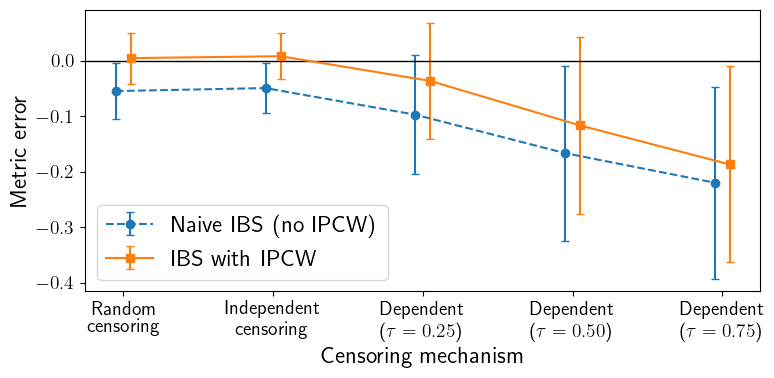

In [7]:
# Plot the results
def pretty_label(s):
    if s == "random":
        return r"\shortstack{Random\\censoring}"
    if s == "indep":
        return r"\shortstack{Independent\\censoring}"
    # dependent tau
    t = float(s)
    return rf"\shortstack{{Dependent\\($\tau={t:.2f}$)}}"


xlabels = [pretty_label(s) for s in summary["setting"]]
x = np.arange(len(xlabels))

y1 = summary["bias_uncens"].values
y2 = summary["bias_ipcw"].values
e1 = summary["bias_uncens_std"].values
e2 = summary["bias_ipcw_std"].values

dx = 0.05  # horizontal offset

plt.figure(figsize=(8, 4))
plt.errorbar(
    x - dx, y1, yerr=e1,
    marker="o", capsize=3, linestyle="--",
    label="Naive IBS (no IPCW)"
)

plt.errorbar(
    x + dx, y2, yerr=e2,
    marker="s", capsize=3, linestyle="-",
    label="IBS with IPCW"
)

plt.axhline(0.0, linewidth=1, color="black")
plt.xticks(x, xlabels)
plt.xlabel("Censoring mechanism")
plt.ylabel("Metric error")
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/ibs_error_curve.pdf", format='pdf', bbox_inches='tight')
plt.show()

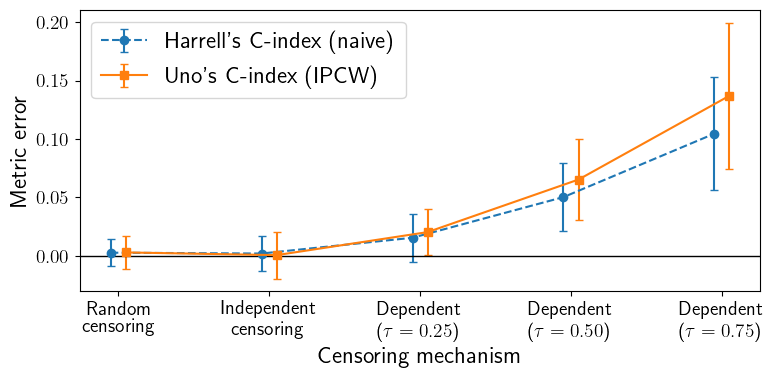

In [8]:
# CI biases
y1 = summary["bias_ci_harrell"].values
y2 = summary["bias_ci_uno"].values
e1 = summary["bias_ci_harrell_std"].values
e2 = summary["bias_ci_uno_std"].values

dx = 0.05  # horizontal offset

plt.figure(figsize=(8, 4))
plt.errorbar(
    x - dx, y1, yerr=e1,
    marker="o", capsize=3, linestyle="--",
    label="Harrell's C-index (naive)"
)
plt.errorbar(
    x + dx, y2, yerr=e2,
    marker="s", capsize=3, linestyle="-",
    label="Uno's C-index (IPCW)"
)

plt.axhline(0.0, linewidth=1, color="black")
plt.xticks(x, xlabels)
plt.xlabel("Censoring mechanism")
plt.ylabel("Metric error")
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/ci_error_curve.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [9]:
summary

,setting,tau,censor_rate,censor_rate_std,n_events,bias_uncens,bias_ipcw,bias_uncens_std,bias_ipcw_std,ibs_true,ibs_uncens,ibs_ipcw,bias_ci_harrell,bias_ci_uno,bias_ci_harrell_std,bias_ci_uno_std,ci_true,ci_harrell,ci_uno
0,random,0.00,0.735887,0.158351,2641.13,-0.054805,0.004575,0.050497,0.046025,0.090018,0.035213,0.094593,0.002698,0.002911,0.011724,0.014011,0.634354,0.637052,0.637265
1,indep,0.00,0.684266,0.216657,3157.34,-0.049409,0.007975,0.045401,0.040946,0.083701,0.034292,0.091675,0.001978,0.000598,0.015185,0.020030,0.634063,0.636041,0.634661
2,0.25,0.25,0.703080,0.239587,2969.20,-0.097341,-0.036608,0.106699,0.104787,0.132177,0.034837,0.095570,0.015482,0.020314,0.020530,0.019985,0.628132,0.643614,0.648445
3,0.5,0.50,0.724233,0.263493,2757.67,-0.166560,-0.116697,0.157555,0.158934,0.199458,0.032898,0.082761,0.050269,0.065315,0.029435,0.034371,0.617933,0.668202,0.683248
4,0.75,0.75,0.746450,0.286058,2535.50,-0.219831,-0.186880,0.172561,0.176483,0.245344,0.025513,0.058464,0.104605,0.137080,0.048259,0.062436,0.609206,0.713811,0.746286


In [10]:
res

,setting,tau,seed,censor_rate,n_events,ibs_true,ibs_uncens,ibs_ipcw,bias_uncens,bias_ipcw,ci_true,ci_harrell,ci_uno,bias_ci_harrell,bias_ci_uno,censor_use_x,use_copula
0,random,0.00,0,0.6815,3185,0.074658,0.040113,0.093131,-0.034545,0.018473,0.628584,0.644028,0.642889,0.015444,0.014305,False,False
1,indep,0.00,0,0.9288,712,0.077721,0.016024,0.083097,-0.061697,0.005376,0.624871,0.657922,0.654744,0.033052,0.029873,True,False
2,0.25,0.25,0,0.9596,404,0.376532,0.017949,0.086047,-0.358583,-0.290485,0.615689,0.614420,0.622094,-0.001269,0.006405,True,True
3,0.5,0.50,0,0.9786,214,0.501660,0.012491,0.048245,-0.489169,-0.453415,0.550014,0.526966,0.588846,-0.023049,0.038831,True,True
4,0.75,0.75,0,0.9943,57,0.547578,0.004439,0.006336,-0.543139,-0.541242,0.571593,0.702089,0.749151,0.130495,0.177558,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,random,0.00,99,0.9370,630,0.138575,0.015251,0.064414,-0.123324,-0.074161,0.645671,0.619298,0.626034,-0.026373,-0.019637,False,False
496,indep,0.00,99,0.8918,1082,0.070634,0.019275,0.113760,-0.051360,0.043125,0.645925,0.638559,0.643826,-0.007366,-0.002099,True,False
497,0.25,0.25,99,0.9286,714,0.202559,0.023031,0.113102,-0.179528,-0.089456,0.628850,0.630840,0.654470,0.001990,0.025620,True,True
498,0.5,0.50,99,0.9619,381,0.359772,0.015436,0.075651,-0.344336,-0.284121,0.633742,0.682597,0.708004,0.048856,0.074262,True,True


In [14]:
summary = (
    res
    .groupby("setting")
    .agg(
        n_events_mean=("n_events", "mean"),
        censor_rate_mean=("censor_rate", "mean"),
        ci_oracle_mean=("ci_true", "mean"),
        ci_oracle_std=("ci_true", "std"),
        ibs_oracle_mean=("ibs_true", "mean"),
        ibs_oracle_std=("ibs_true", "std"),
    )
)

summary["events_cens"] = (
    summary["n_events_mean"].round(0).astype(int).astype(str)
    + " ("
    + (100 * summary["censor_rate_mean"]).round(1).astype(str)
    + "\\%)"
)

summary["CI_oracle"] = (
    summary["ci_oracle_mean"].round(3).astype(str)
    + " \\pm "
    + summary["ci_oracle_std"].round(3).astype(str)
)

summary["IBS_oracle"] = (
    summary["ibs_oracle_mean"].round(3).astype(str)
    + " \\pm "
    + summary["ibs_oracle_std"].round(3).astype(str)
)

summary[["events_cens", "CI_oracle", "IBS_oracle"]]


,events_cens,CI_oracle,IBS_oracle
setting,,,
0.25,2969 (70.3\%),0.628 \pm 0.021,0.132 \pm 0.096
0.5,2758 (72.4\%),0.618 \pm 0.025,0.199 \pm 0.144
0.75,2536 (74.6\%),0.609 \pm 0.03,0.245 \pm 0.157
indep,3157 (68.4\%),0.634 \pm 0.018,0.084 \pm 0.037
random,2641 (73.6\%),0.634 \pm 0.018,0.09 \pm 0.044
